<a href="https://colab.research.google.com/github/andyharless/covid19states/blob/master/covid_positive_rate_etc_by_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
# Data from https://covidtracking.com
url = 'https://docs.google.com/spreadsheets/d/18oVRrHj3c183mHmq3m89_163yuYltLNlOmPerQ18E8w'

In [0]:
# Get data as a spreadsheet workbook
wb = gc.open_by_url(url)

In [0]:
# Get the sheet with daily data by state
data = wb.worksheet('States daily 4 pm ET').get_all_values()

In [6]:
# Convert to a Pandas DataFrame
full_df = pd.DataFrame(data)
full_df.head()

0      1         2   ...      12                  13              14
0      Date  State  Positive  ...  Deaths  Data Quality Grade  Last Update ET
1  20200508     AK       377  ...      10                   C  5/8/2020 00:00
2  20200508     AL     9,221  ...     375                   B  5/8/2020 00:00
3  20200508     AR     3,694  ...      88                   B  5/8/2020 08:15
4  20200508     AS         0  ...       0                   F  5/3/2020 00:00

[5 rows x 15 columns]

In [0]:
# Use the first row of data as column names
def set_first_row_as_header(df):
  new_header = df.iloc[0] # Grab the first row for the header
  df = df[1:]             # Take the data less the header row
  df.columns = new_header # Set the header row as the df header
  return(df)

In [0]:
# Convert data to the appropriate types
def convert_dtypes(df):
  for c in df.columns:
    if c=='Date':                   # 'Date' is a date
      df[c] = pd.to_datetime(df[c])  
    elif c=='State':                # 'State' is a string (default, so no action)
      pass                           
    else:                           # The rest are numeric, need to remove commas
      df[c] = pd.to_numeric(df[c].str.replace(',',''), errors='coerce')
  return(df)

In [0]:
# Proccess the data frames and calculate positive rates
full_df = set_first_row_as_header(full_df)
full_df = convert_dtypes(full_df)
full_df['Total'] = full_df.Positive+full_df.Negative.fillna(0)  # New definition
full_df['posrate'] = full_df.Positive / full_df.Total

In [10]:
# Find states with more than 1000 confirmed cases,
#   arranged in descending order of number of cases
current = full_df.sort_values(['Date', 'Positive'], ascending=False).head(50)
states = current[current.Positive>1000].State.values
states

array(['NY', 'NJ', 'MA', 'IL', 'CA', 'PA', 'MI', 'FL', 'TX', 'CT', 'GA',
       'LA', 'MD', 'IN', 'OH', 'VA', 'CO', 'WA', 'TN', 'NC', 'IA', 'RI',
       'AZ', 'MN', 'WI', 'MO', 'AL', 'MS', 'NE', 'SC', 'KS', 'KY', 'DE',
       'UT', 'DC', 'NV', 'NM', 'OK', 'AR', 'SD', 'OR', 'NH', 'ID', 'PR',
       'ND', 'ME', 'WV'], dtype=object)

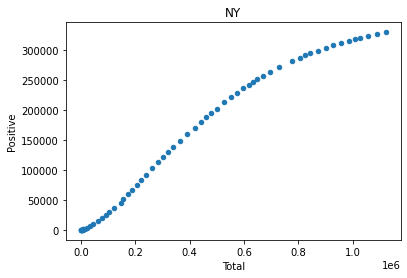

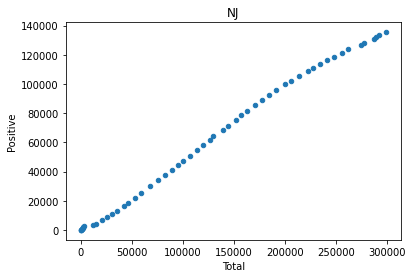

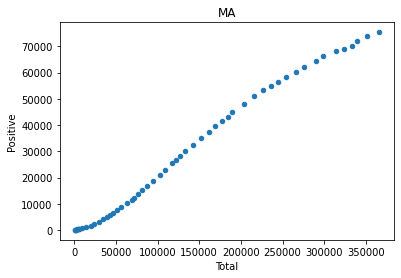

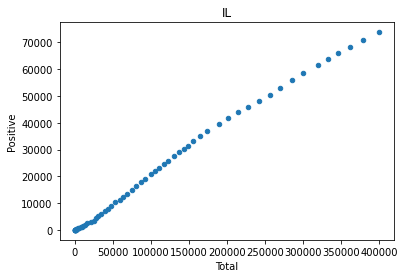

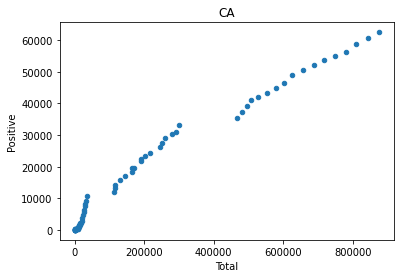

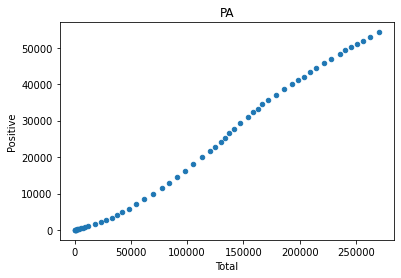

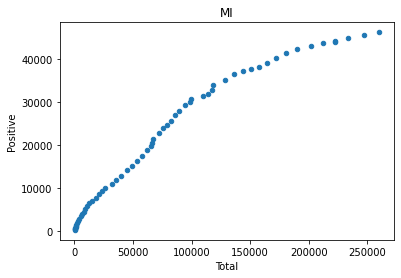

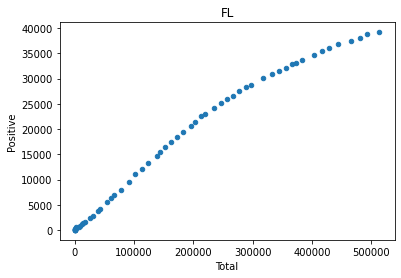

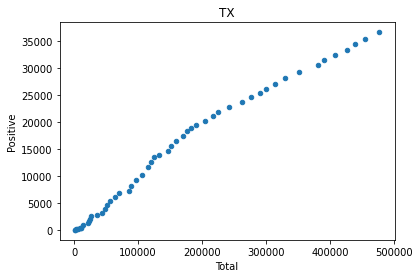

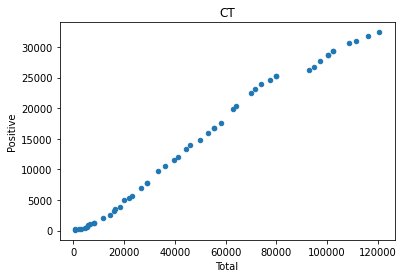

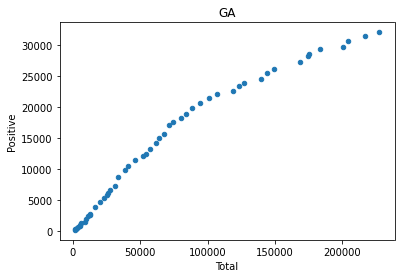

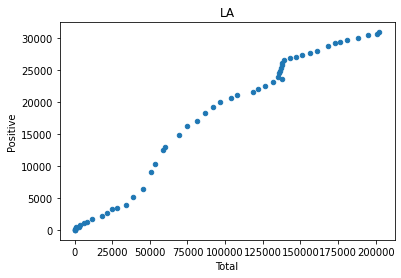

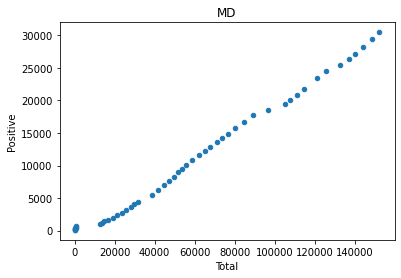

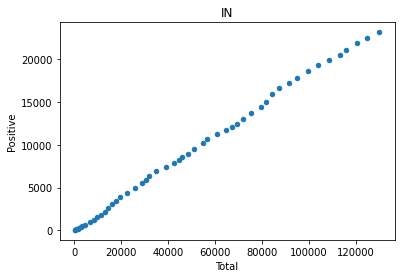

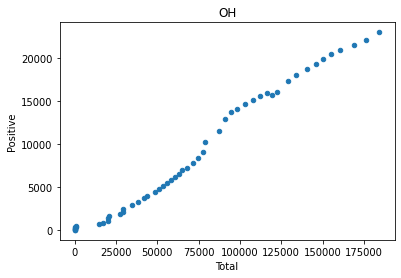

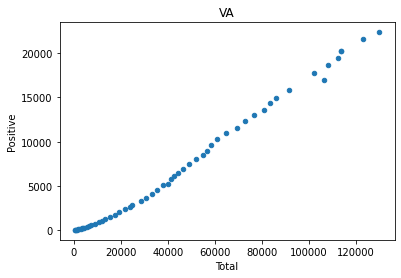

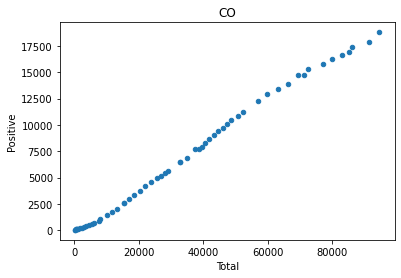

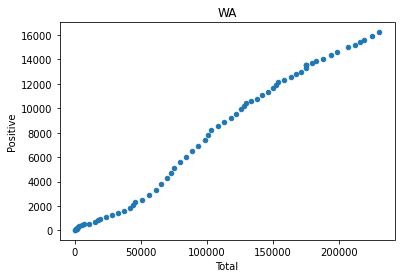

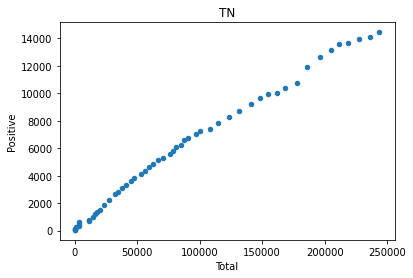

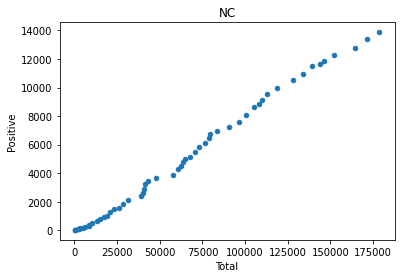

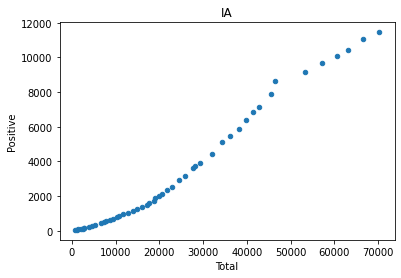

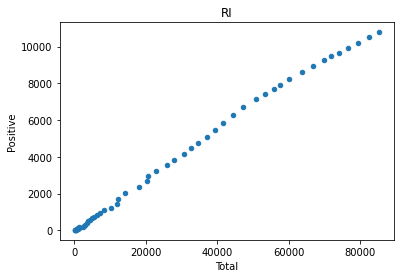

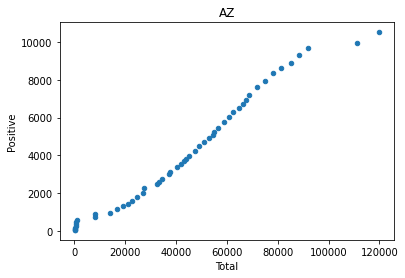

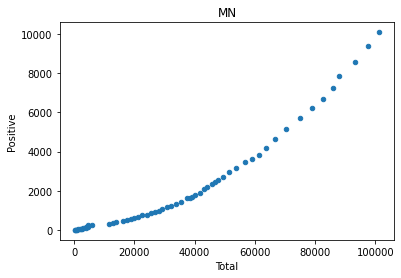

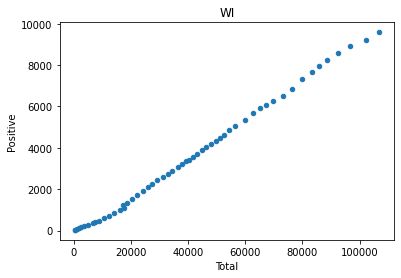

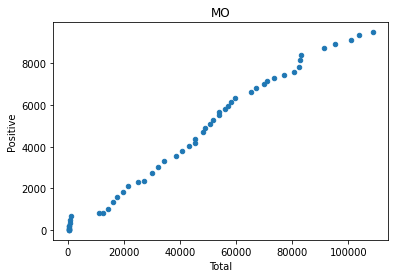

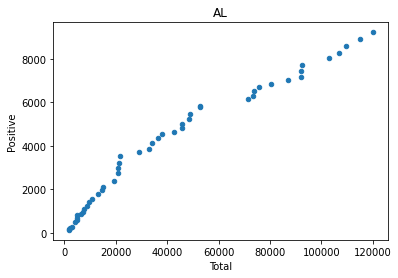

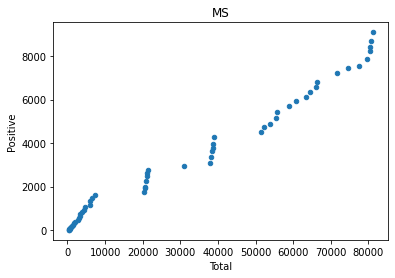

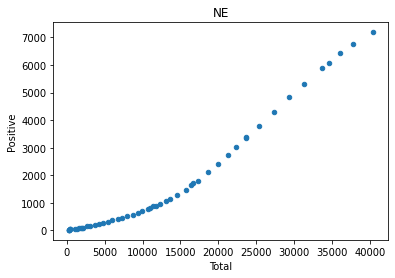

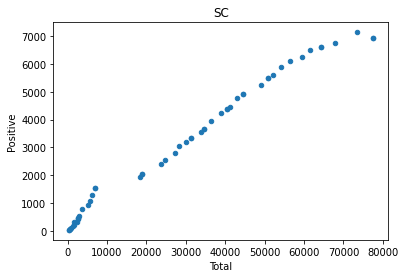

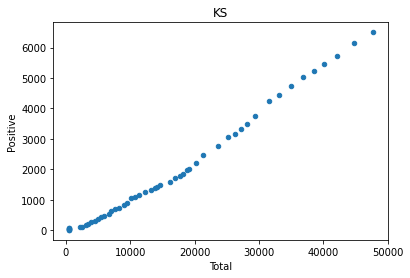

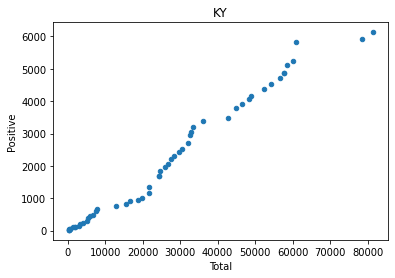

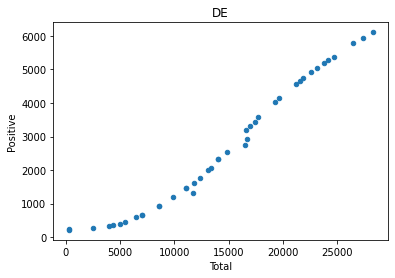

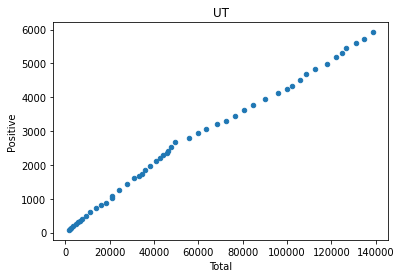

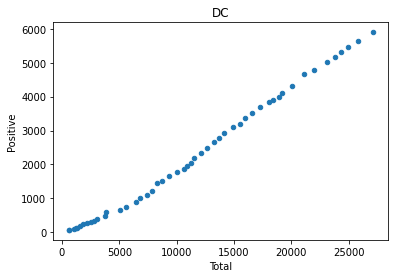

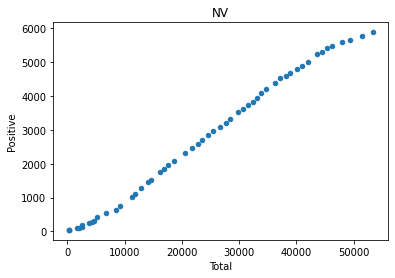

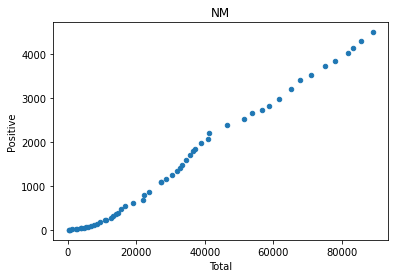

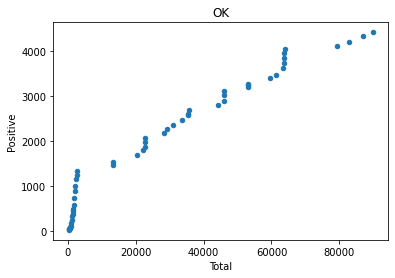

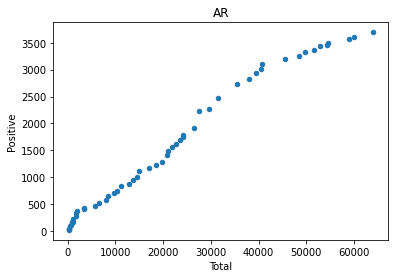

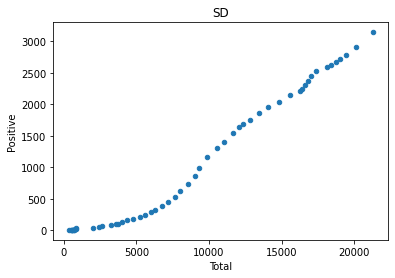

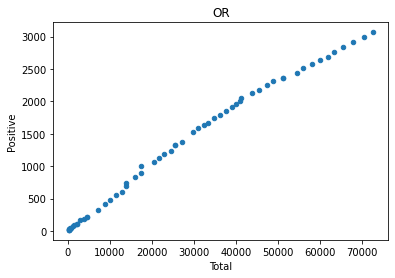

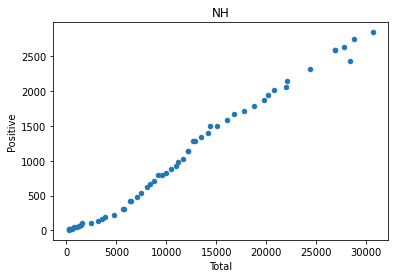

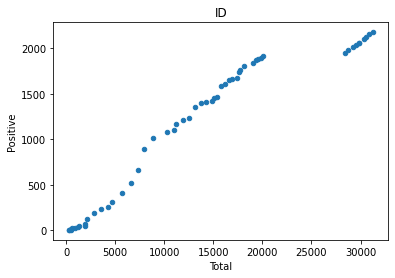

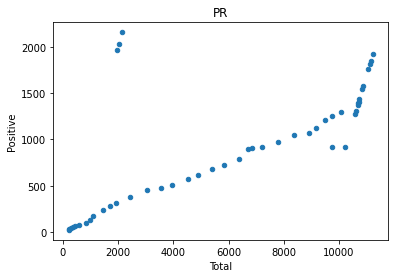

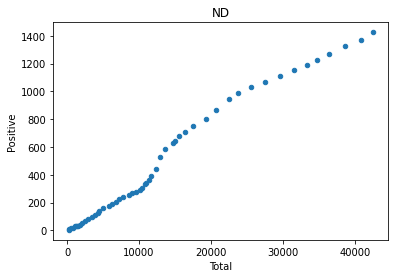

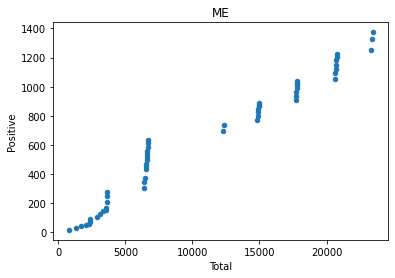

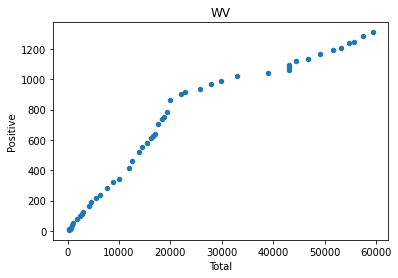

In [11]:
# Scatterplot  "Number of positive tests (confirmed cases)" 
#          vs. "Total number of cumulative tests"  (by state)

# We hope (but thus far do not find) that these plots will eventually start
#   to look like concave functions.  In other words, states should be testing
#   more and more people and hoping that, as testing is broadened, they find
#   a smaller proportion of infections among those tested.

for state in states:
  df = full_df[full_df.State==state]
  df[df.Total>200][['Total','Positive']].plot(kind='scatter', x='Total', y='Positive', title=state)
  plt.show()

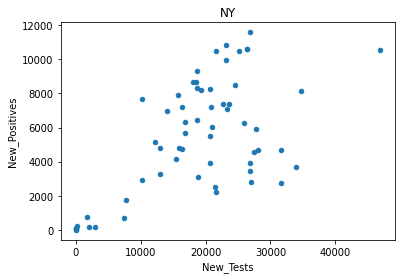

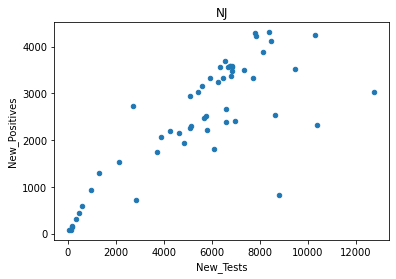

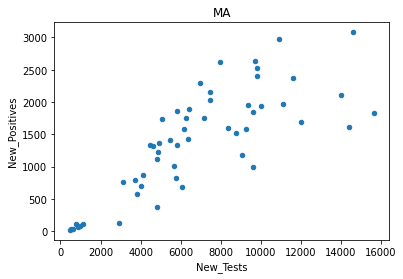

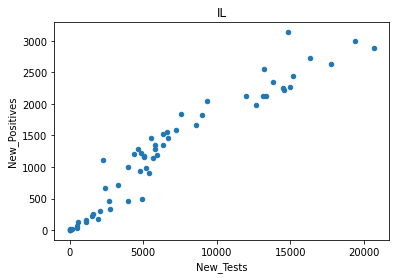

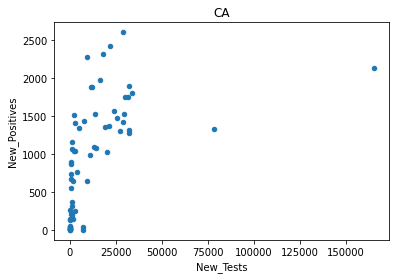

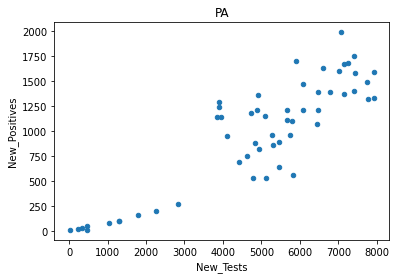

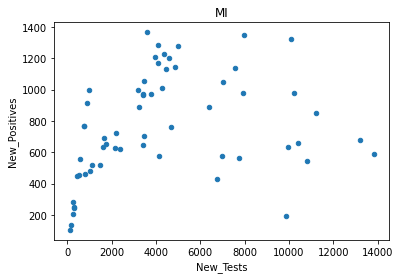

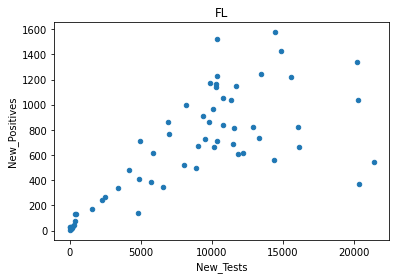

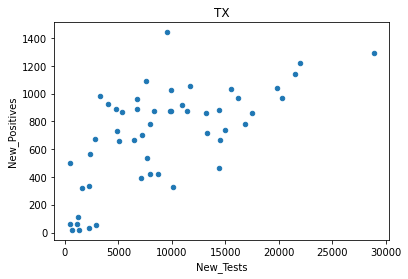

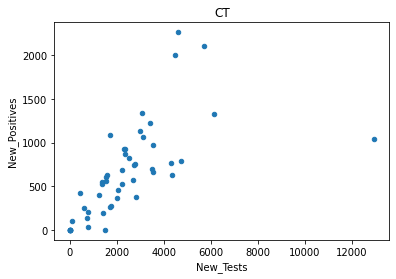

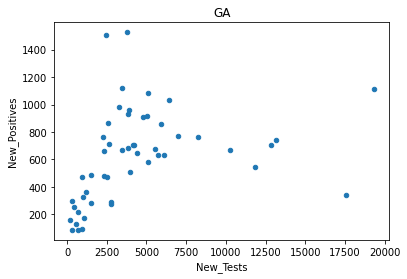

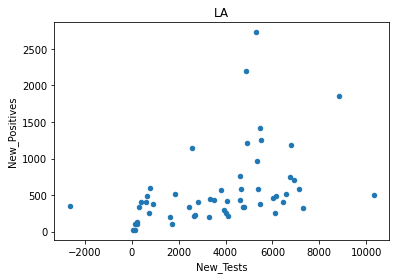

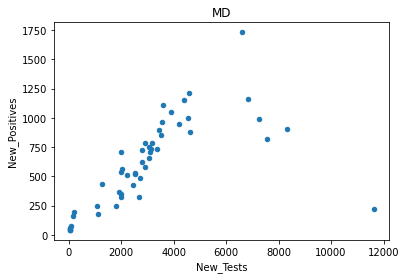

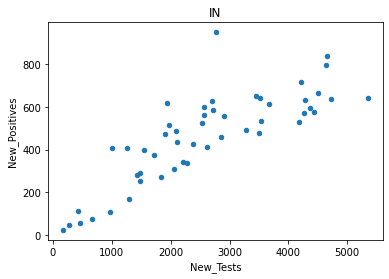

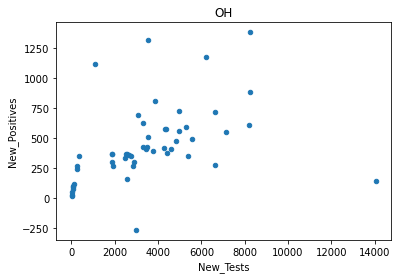

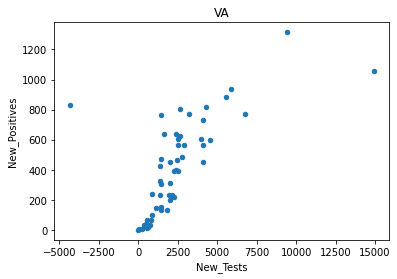

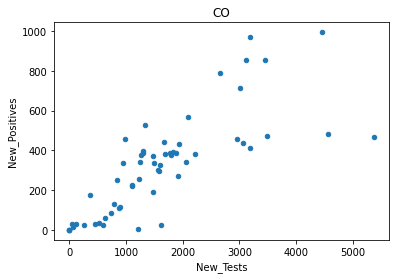

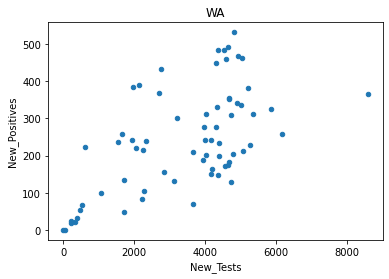

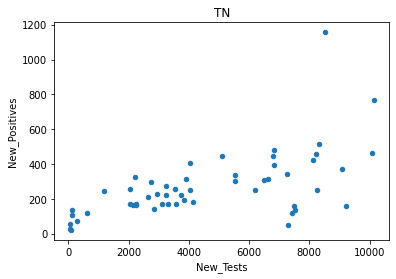

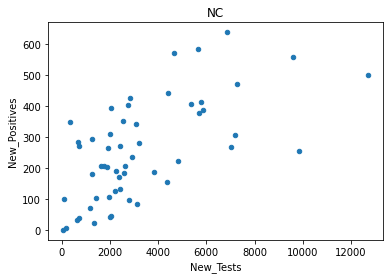

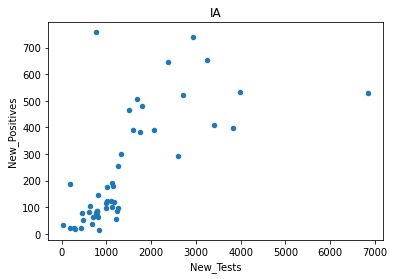

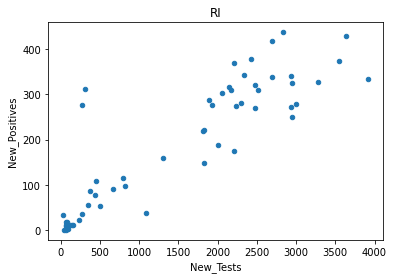

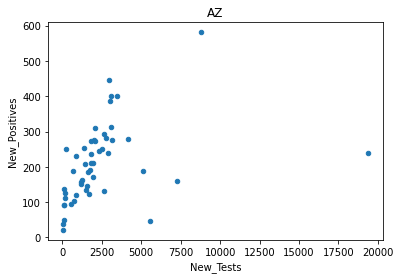

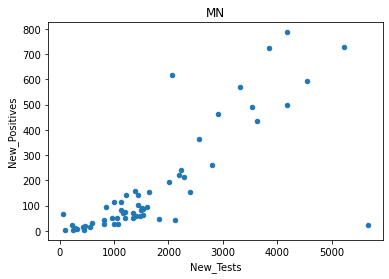

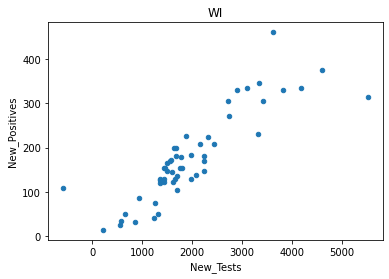

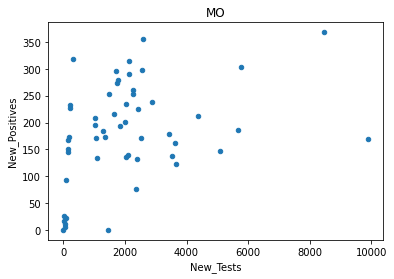

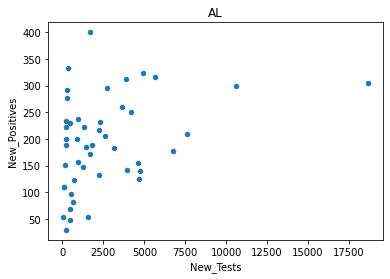

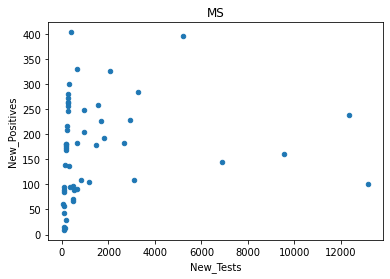

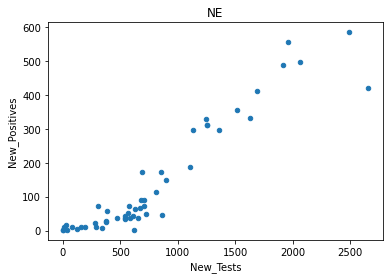

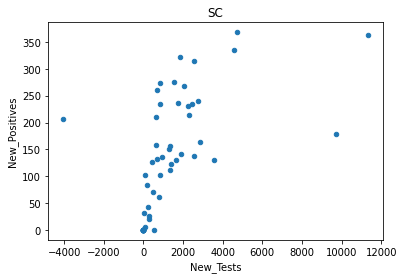

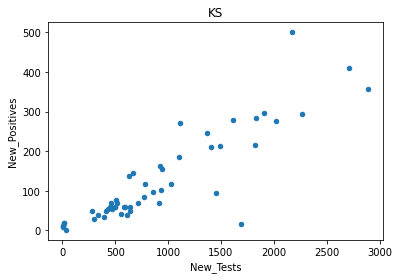

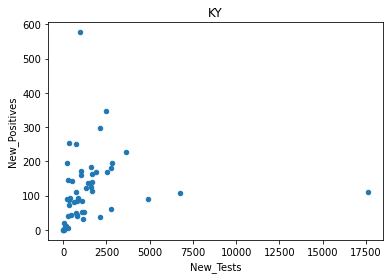

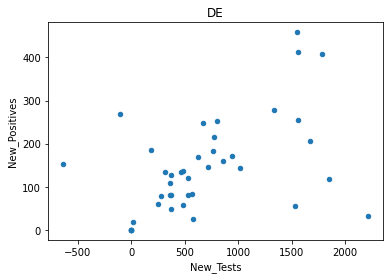

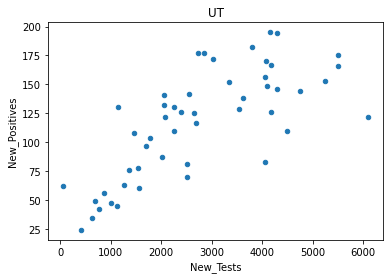

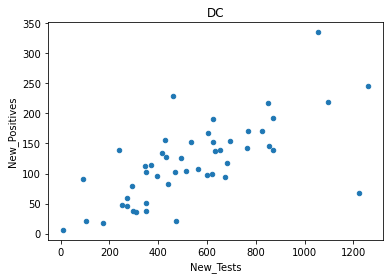

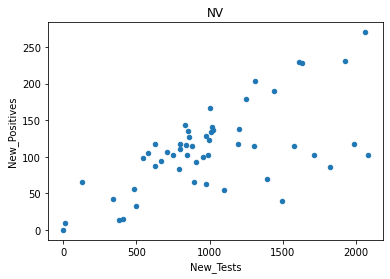

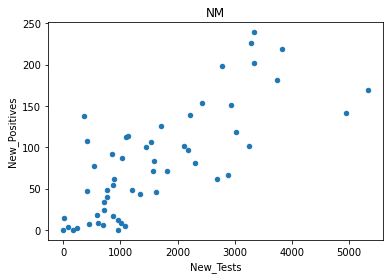

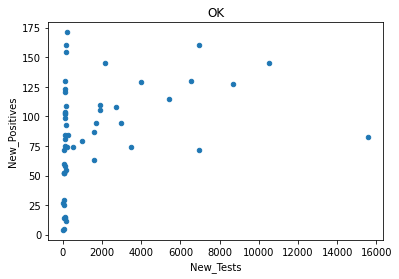

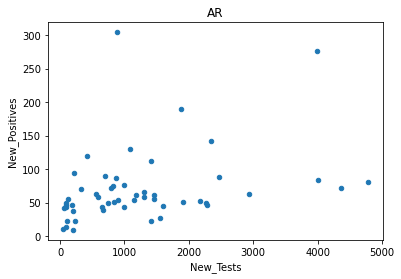

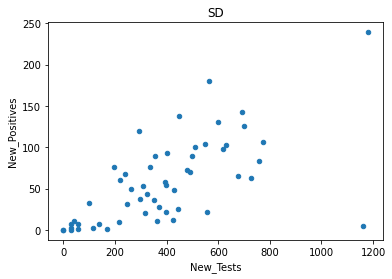

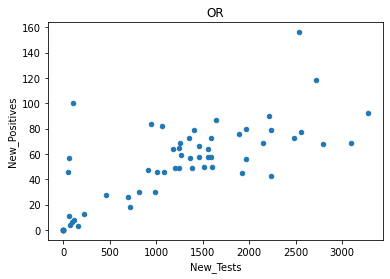

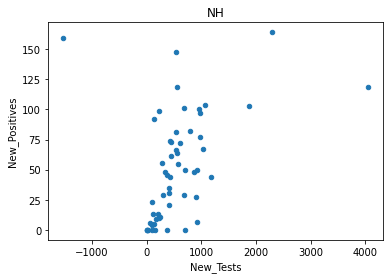

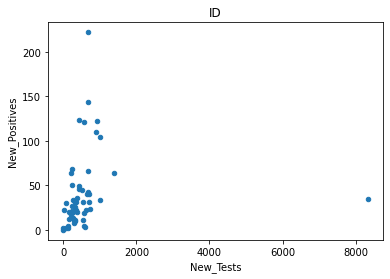

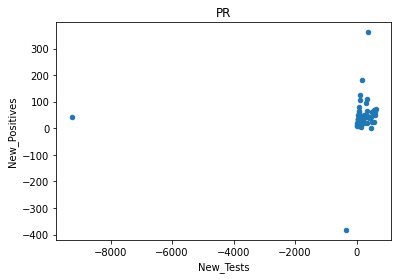

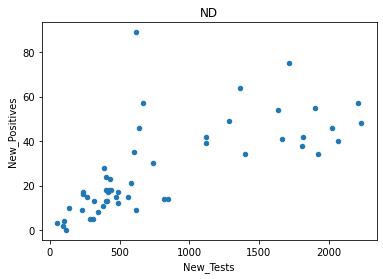

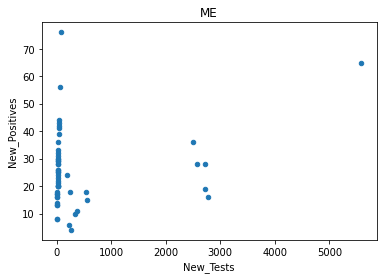

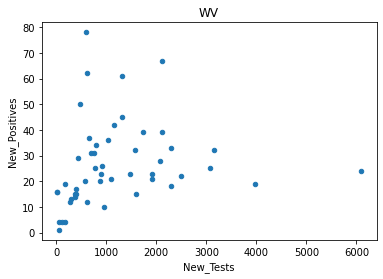

In [12]:
# Scatterplot  "Number of NEW positive tests (latest confirmed cases)" 
#          vs. "Total number of NEW tests"   (by state)

# We hope (but thus far do not find) that these will eventually flatten out.
#   Again, states should be testing more and more people and hoping that, 
#   as testing is broadened, they find a smaller proportion test positive.

for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Tests'] = -df['Total'].diff()
  df['New_Positives'] = -df['Positive'].diff()
  df[df.Total>200][['New_Tests','New_Positives']].plot(kind='scatter', 
                                                       x='New_Tests', 
                                                       y='New_Positives', 
                                                       title=state)
  plt.show()

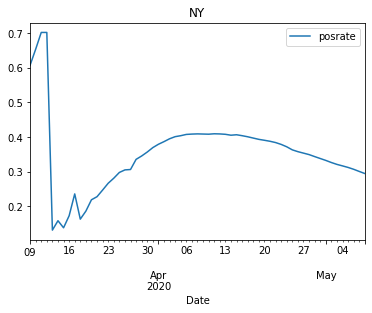

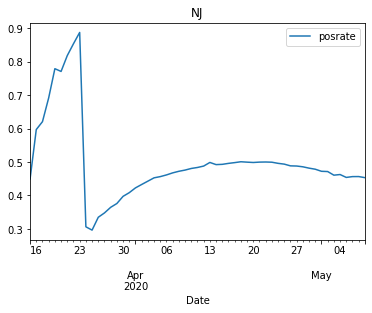

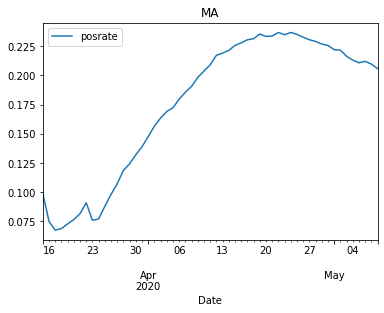

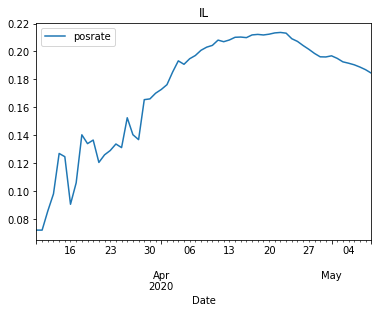

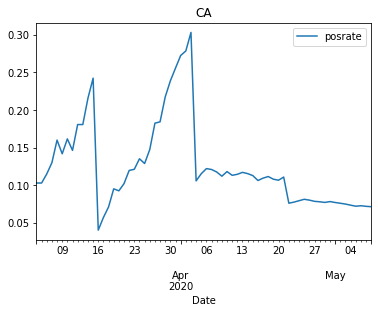

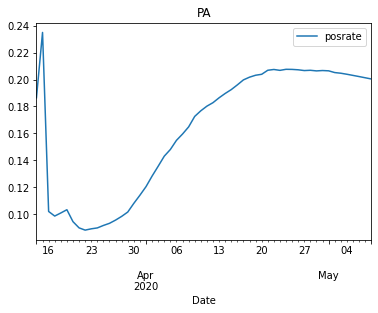

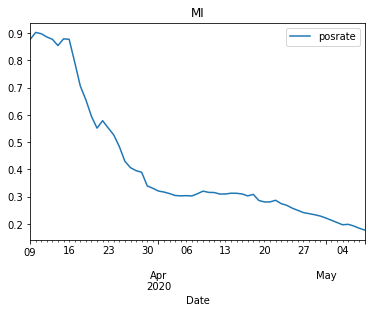

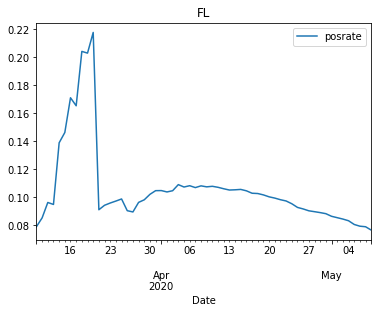

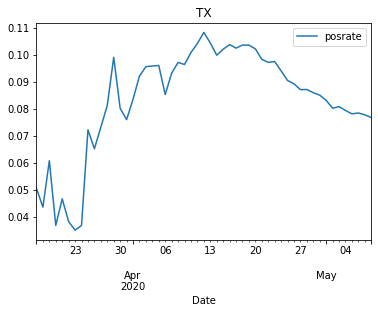

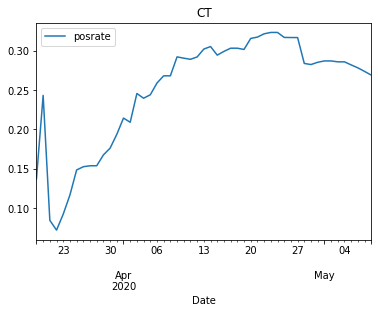

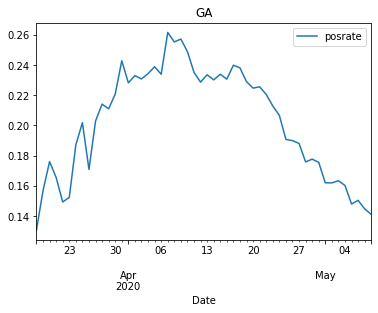

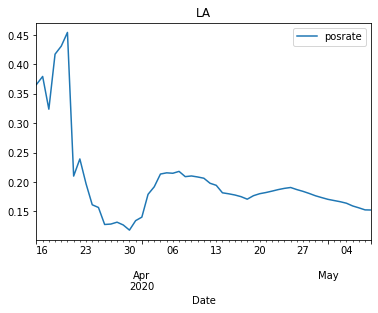

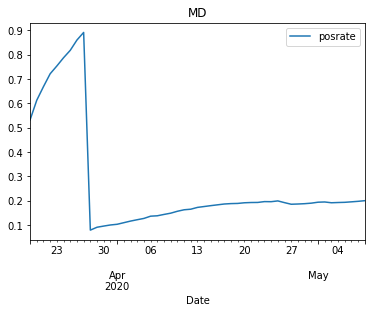

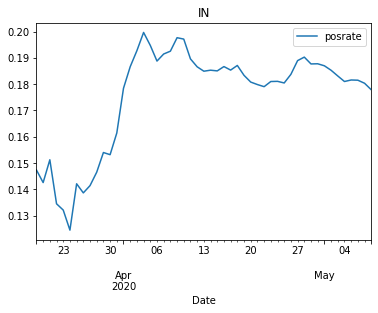

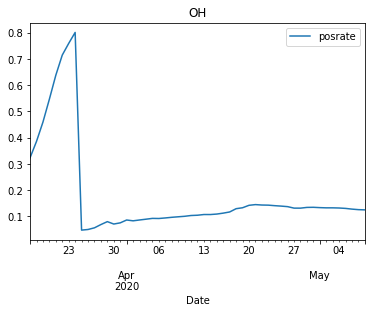

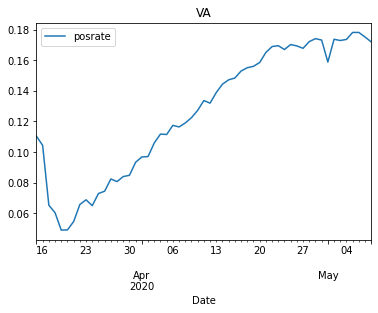

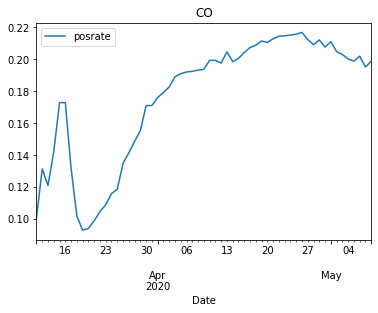

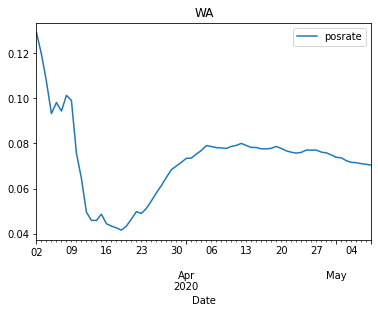

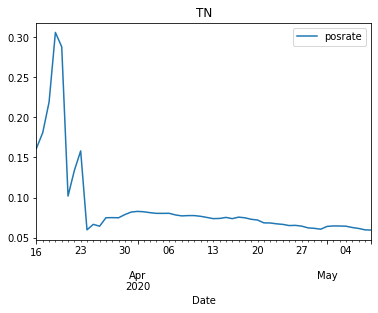

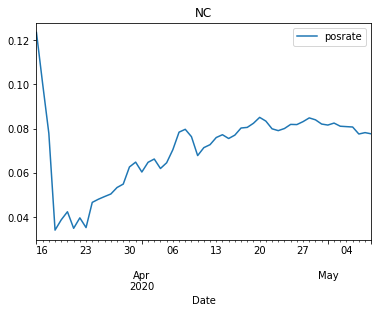

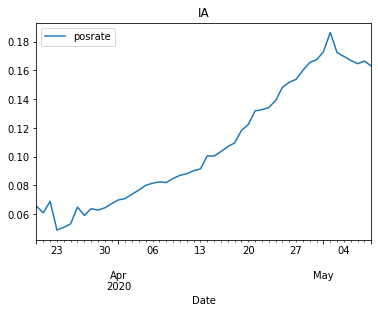

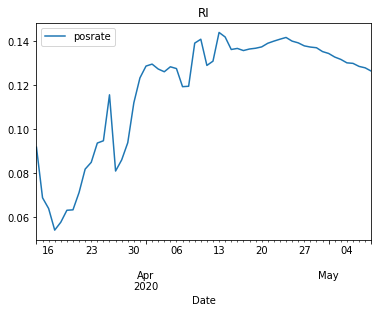

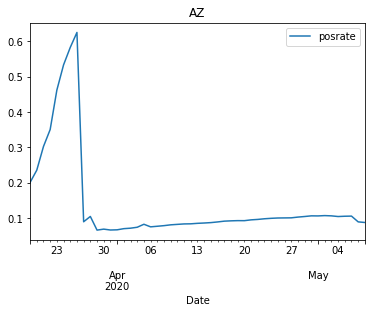

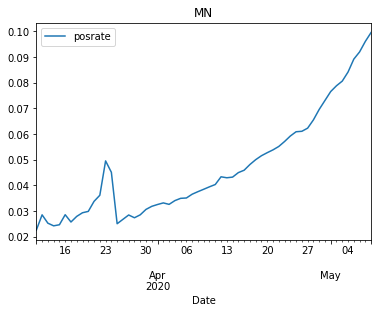

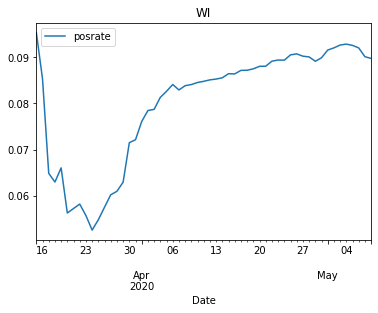

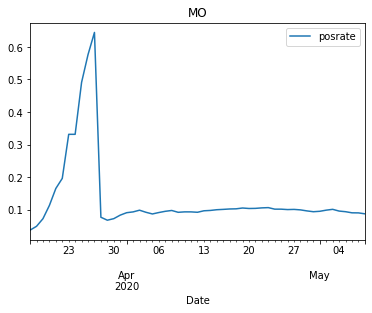

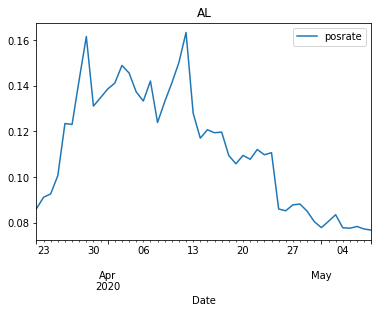

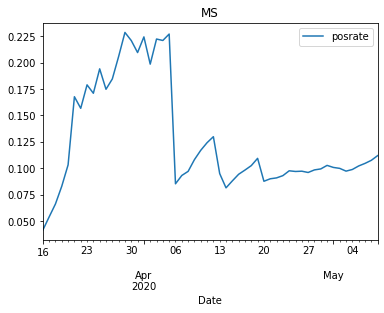

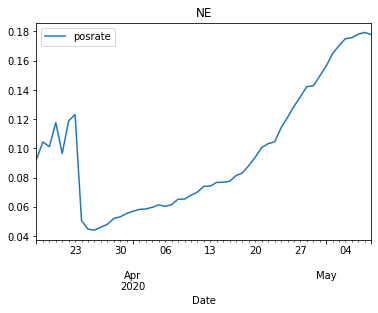

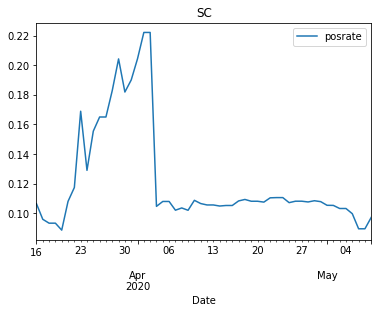

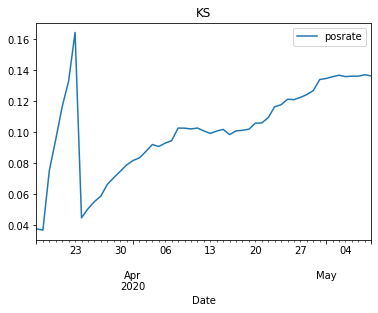

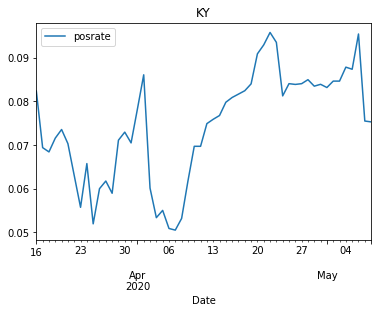

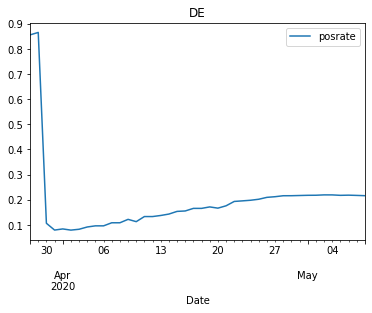

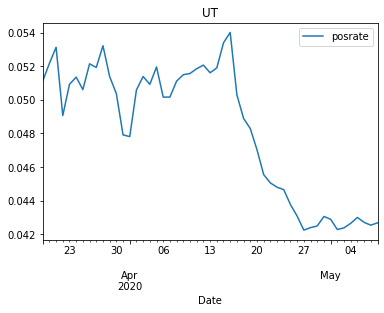

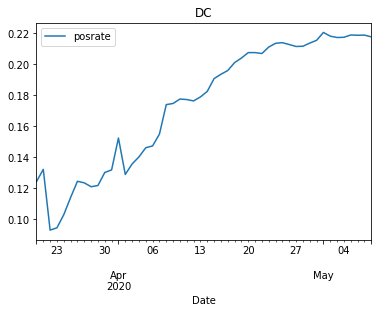

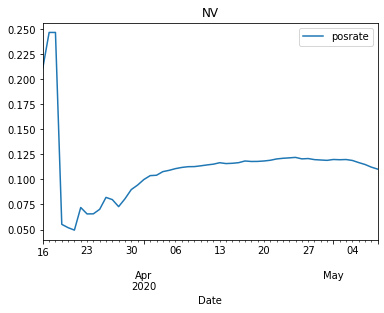

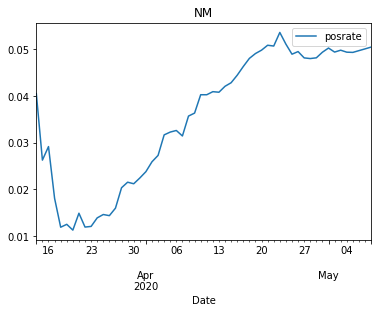

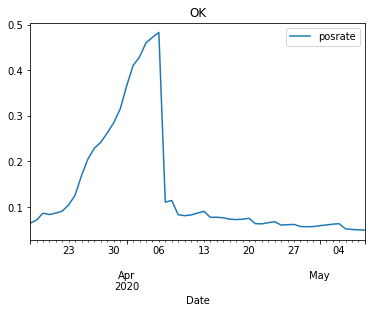

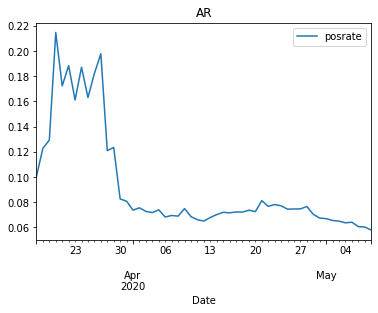

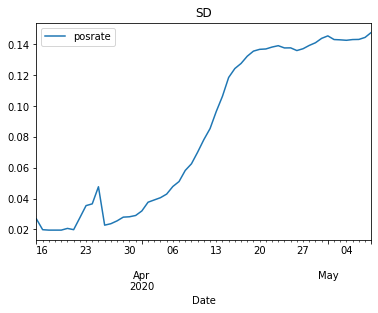

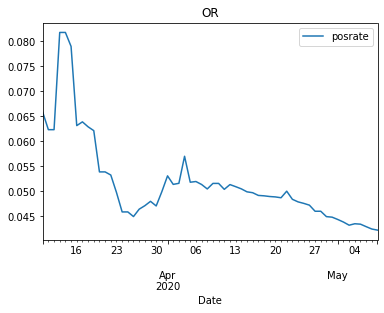

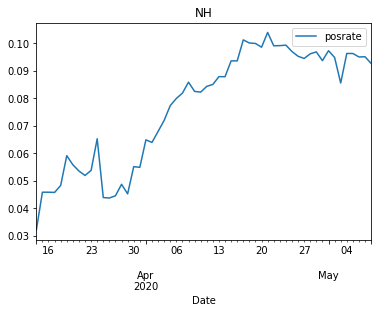

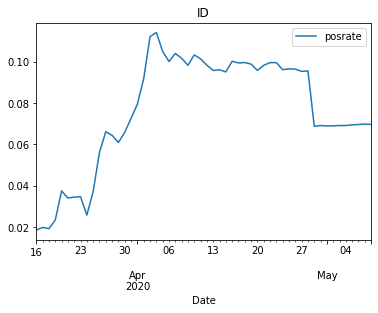

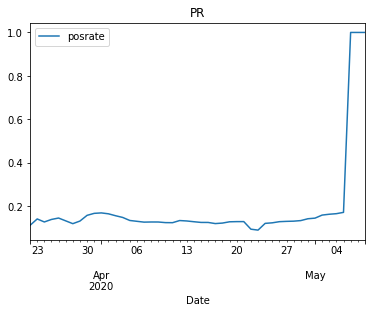

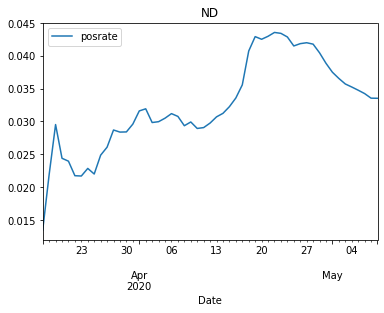

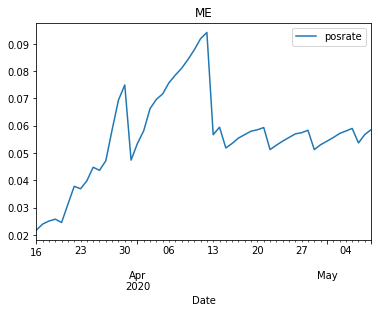

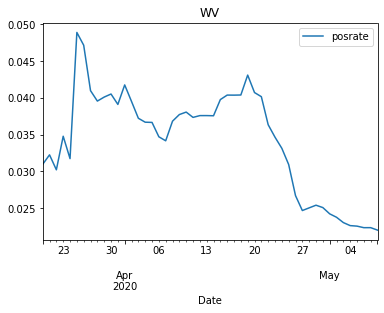

In [13]:
# Plot time series of fraction of tests that are positive (by state)
for state in states:
  df = full_df[full_df.State==state]
  df[df.Total>200][['Date','posrate']].set_index('Date').plot(y='posrate', title=state)
  plt.show()

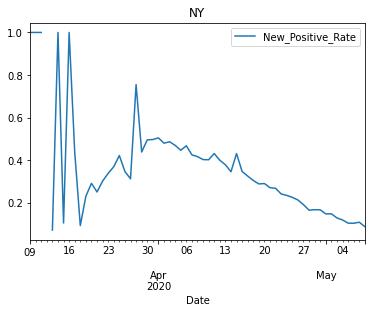

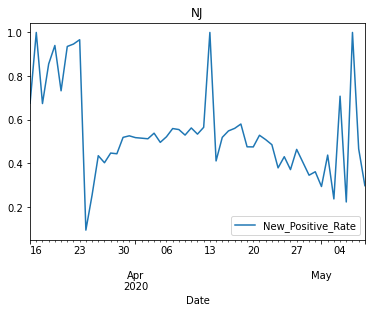

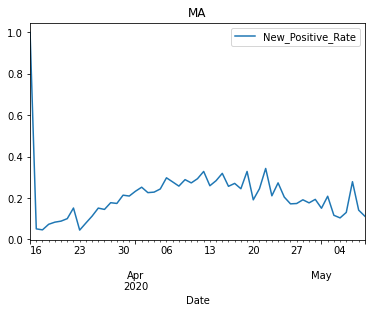

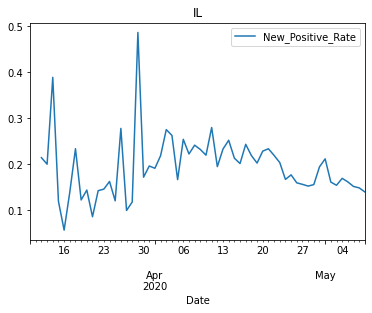

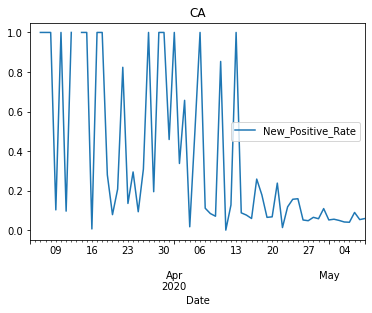

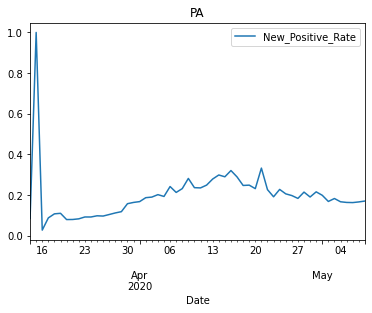

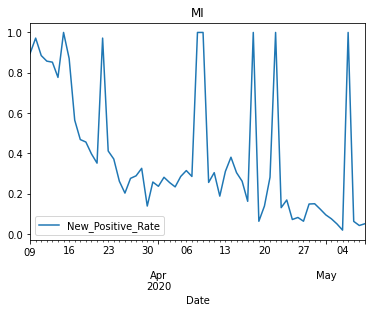

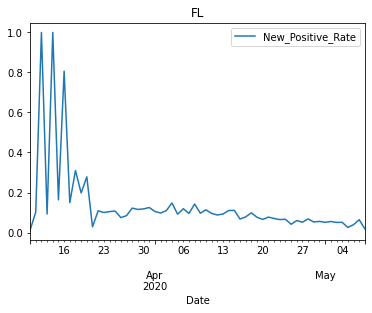

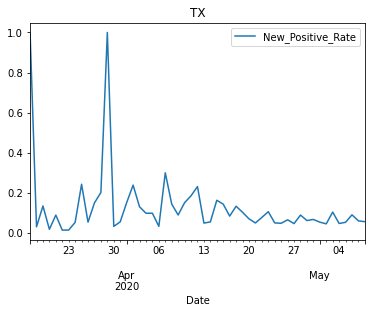

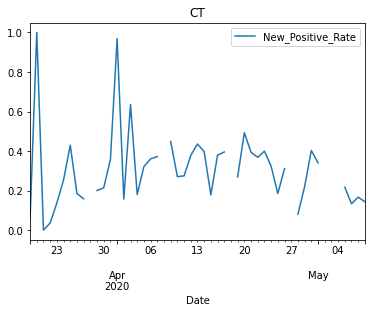

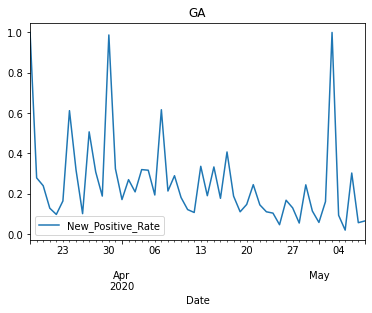

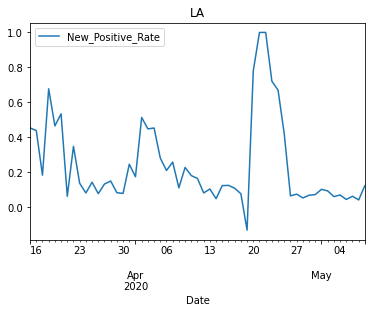

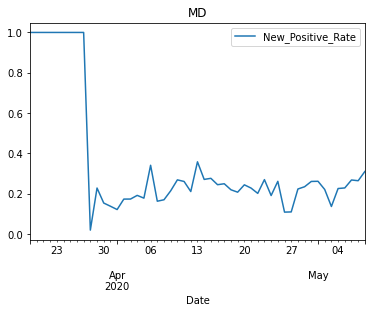

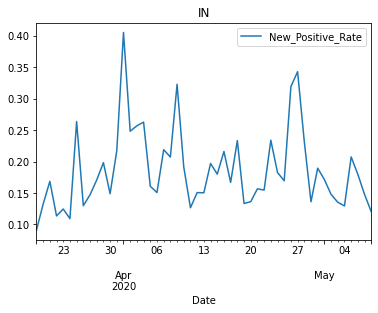

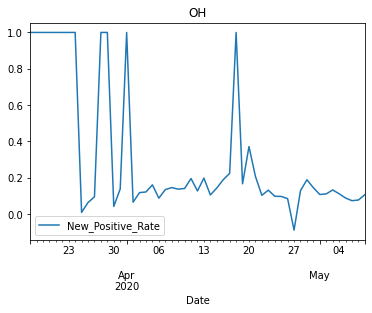

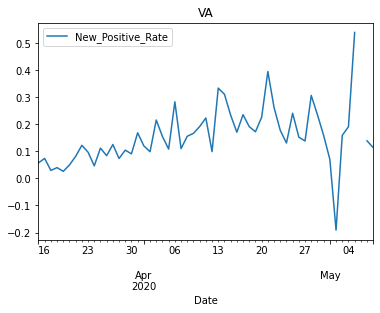

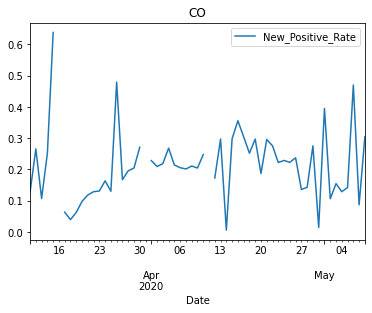

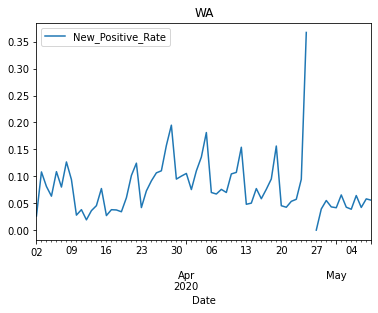

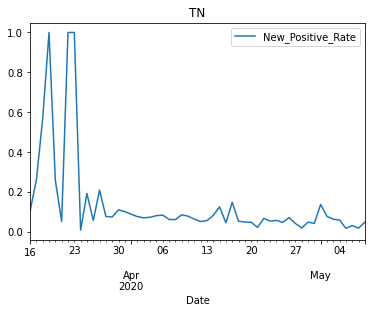

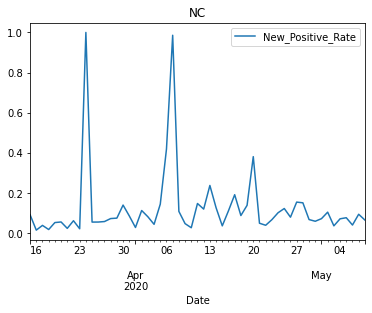

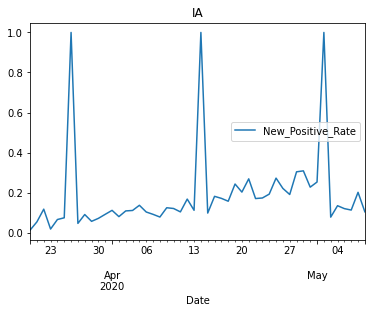

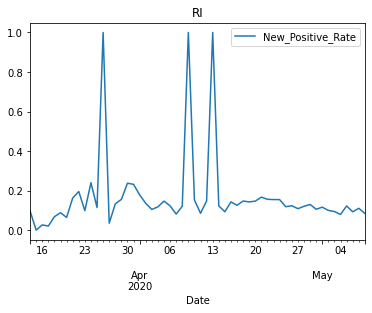

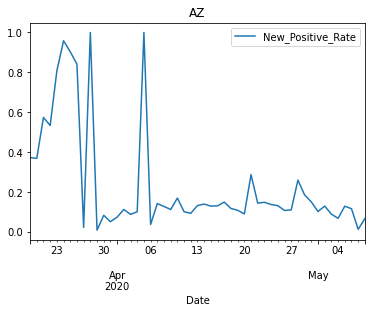

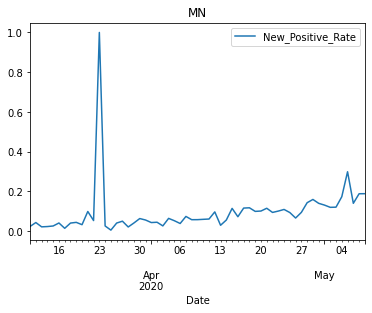

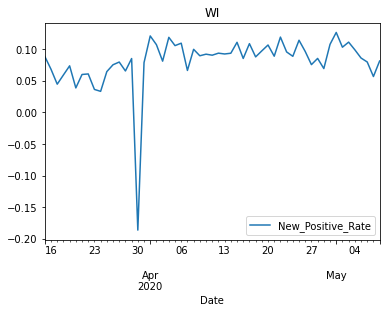

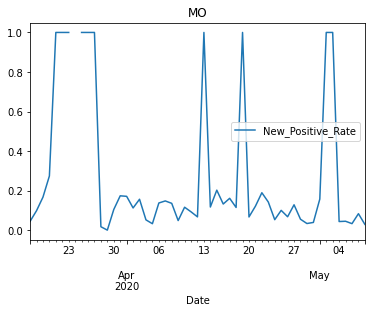

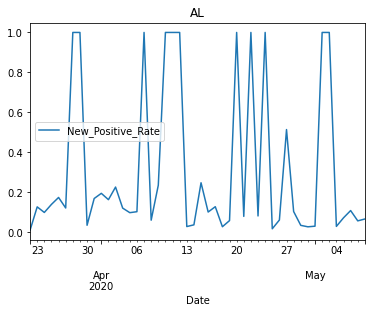

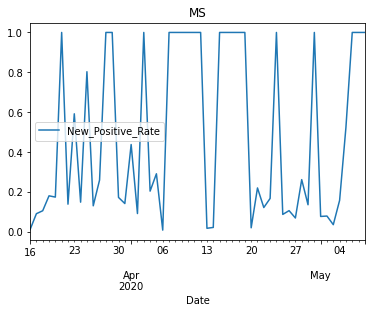

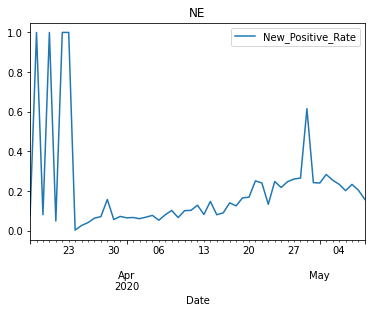

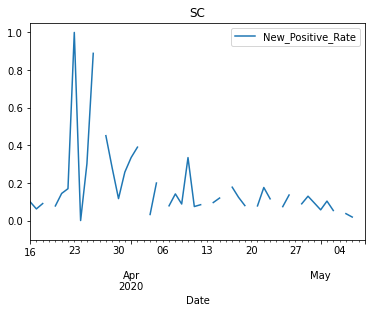

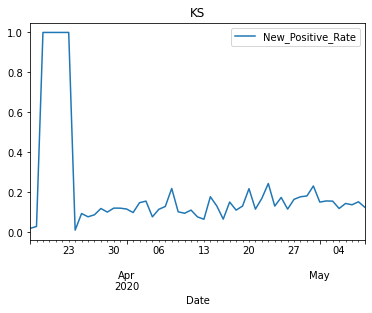

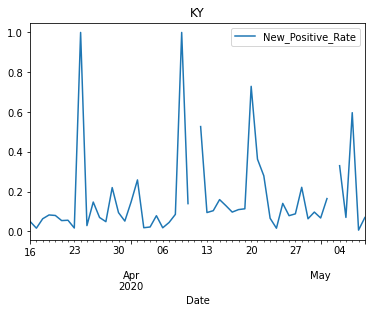

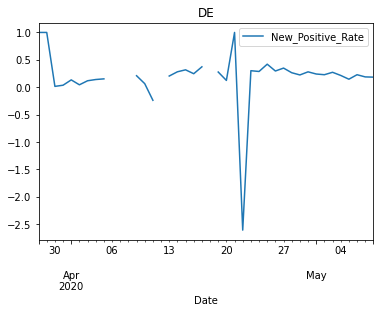

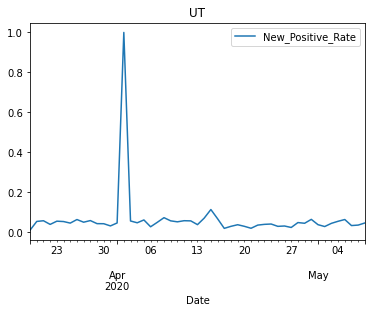

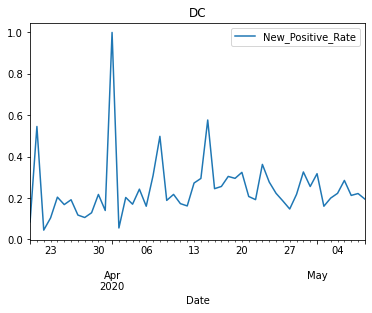

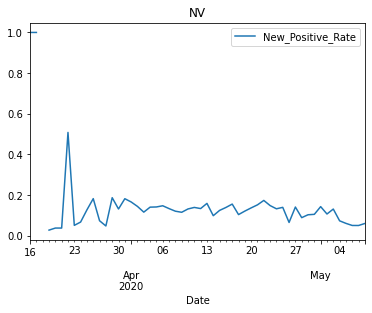

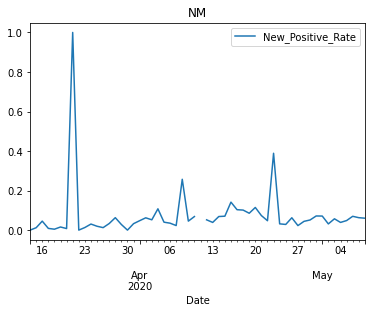

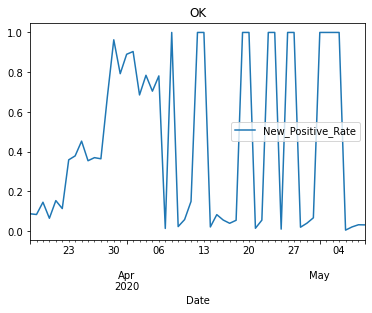

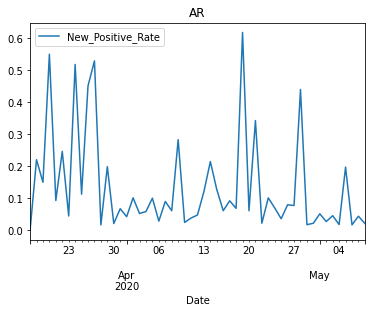

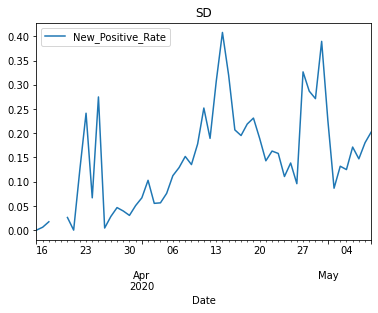

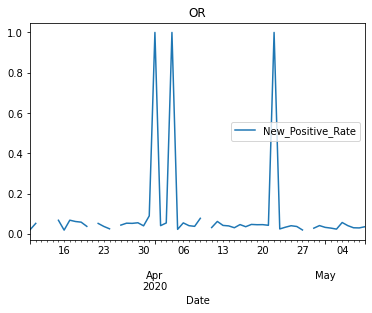

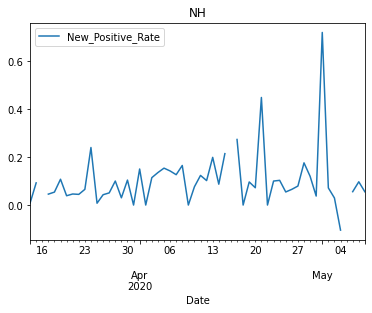

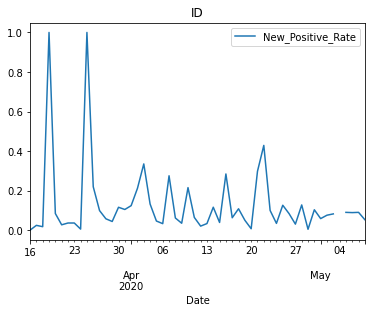

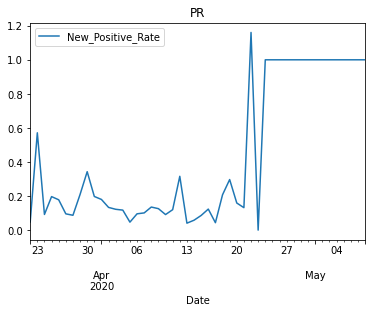

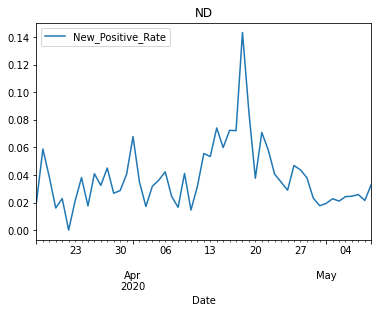

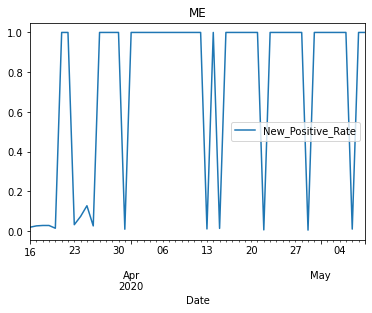

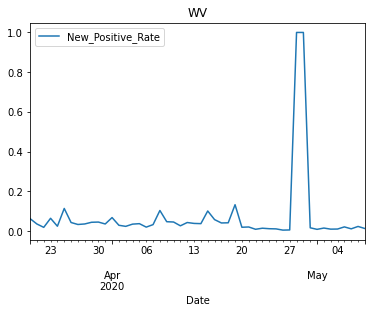

In [14]:
# Plot time series of fraction of NEW tests that are positive, by state
for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Positives'] = -df['Positive'].diff().shift(-1)
  df['New_Negatives'] = -df['Negative'].diff().shift(-1)
  df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
  df[df.Total>200][['Date',
                    'New_Positive_Rate']].set_index('Date').plot(y='New_Positive_Rate', 
                                                                 title=state)
  plt.show()

In [15]:
# Show mean fraction of cumulative positives (over time) by state, 
#   along with standard deviation
#   (These are sorted by increasing standard deviation, so the top of the table
#    represents states that have had the most consistent fraction of positive tests)
# It's noteworthy that most of the standard deviations are small compared to the means
#    and that the means vary quite a lot by state.
# So within-state results (for positive rate) are typically consistent over time
#    whereas positive rate varies a lot from one state to another
df = full_df[full_df.Date>'2020-03-16'][['Date', 'posrate', 'State']]
by_state = df[df.State.isin(states)].groupby('State')
by_state.posrate.agg(['mean', 'std']).sort_values('std')

mean       std
State                    
OR     0.049276  0.004752
ND     0.032456  0.007010
WV     0.032671  0.009461
WA     0.069953  0.011533
KY     0.074382  0.012509
WI     0.079704  0.012775
NM     0.035766  0.014573
NC     0.069099  0.015429
ME     0.056570  0.015934
IN     0.176083  0.019857
TX     0.083237  0.019870
NH     0.079019  0.019929
MN     0.049197  0.020292
RI     0.119983  0.025274
ID     0.077623  0.026601
KS     0.101761  0.028455
FL     0.104461  0.028717
IL     0.182850  0.030477
NV     0.109695  0.034288
SC     0.122111  0.035873
CO     0.180483  0.038388
DC     0.174977  0.039702
NE     0.097721  0.042134
AR     0.092425  0.042138
VA     0.126788  0.042610
PA     0.162132  0.046724
UT     0.057830  0.049263
MS     0.128081  0.050154
SD     0.086145  0.051060
TN     0.087768  0.051250
IA     0.116765  0.055439
CA     0.119551  0.058022
MA     0.178670  0.058622
NY     0.345442  0.062855
LA     0.194888  0.067924
CT     0.252028  0.070298
GA     0.217388  0.115320
MO     0.131944  0.120446
NJ     0.497605  0.123940
OK     0.137252  0.125232
AZ     0.140299  0.130608
MI     0.340748  0.137143
AL     0.166965  0.174487
OH     0.180785  0.183255
PR     0.184849  0.203396
MD     0.272596  0.225964
DE     0.278852  0.228924

In [16]:
# Show mean fraction of DAILY positives (over time) by state, 
#   along with standard deviation
#   (These are sorted by increasing standard deviation, so the top of the table
#    represents states that have had the most consistent fraction of positive tests)
# These are less dramatic than the previous table, but still tend to show
#    that within-state results are typically consistent over time
#    whereas positive rate varies a lot from one state to another
df = full_df.sort_values(['State','Date']).copy()
df['New_Positives'] = df['Positive'].diff()  # Kluge because it's wrong when the state changes
df['New_Negatives'] = df['Negative'].diff()  #   but OK because we use only after 3/16
df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
df = df[df.Date>'2020-03-16'][['Date', 'New_Positive_Rate', 'State']]
by_state = df[df.State.isin(states)].groupby('State')
by_state.New_Positive_Rate.agg(['mean', 'std']).sort_values('std')

mean       std
State                    
ND     0.038762  0.023429
WI     0.081484  0.043501
FL     0.094067  0.052881
WA     0.084379  0.056921
IL     0.194548  0.062370
IN     0.189553  0.065664
PA     0.188094  0.066665
MA     0.200528  0.078242
SD     0.154719  0.099691
CO     0.205274  0.101266
VA     0.159308  0.108335
NH     0.104124  0.121765
MN     0.102104  0.136760
NV     0.138751  0.139731
NY     0.314908  0.140945
NM     0.077868  0.144589
DC     0.247781  0.150039
AR     0.134249  0.157240
TX     0.129868  0.185159
NC     0.128432  0.188813
WV     0.072539  0.189299
ID     0.134402  0.196763
NJ     0.530371  0.201754
SC     0.173756  0.204245
RI     0.175324  0.208402
UT     0.100969  0.222946
KY     0.169188  0.223698
TN     0.137935  0.229690
OR     0.101256  0.232315
CT     0.337472  0.239448
GA     0.269218  0.245918
NE     0.211588  0.248598
LA     0.235372  0.250821
KS     0.208868  0.262120
MI     0.314112  0.274274
AZ     0.239737  0.274613
IA     0.236200  0.283921
MD     0.378482  0.326241
CA     0.299395  0.349929
MO     0.274169  0.361570
OH     0.322748  0.374745
PR     0.400767  0.415470
OK     0.451094  0.416760
AL     0.376489  0.421200
MS     0.491489  0.422564
ME     0.743835  0.431962
DE     0.370598  0.576263

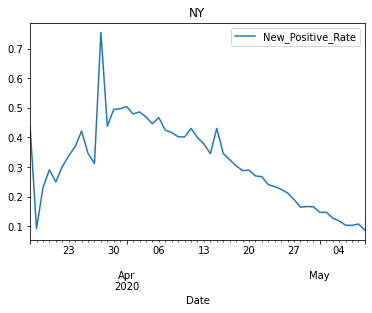

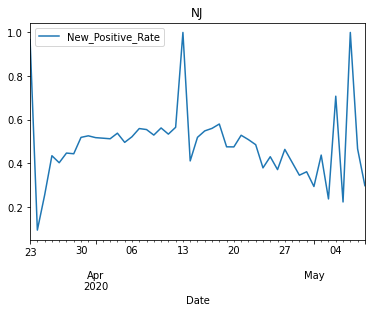

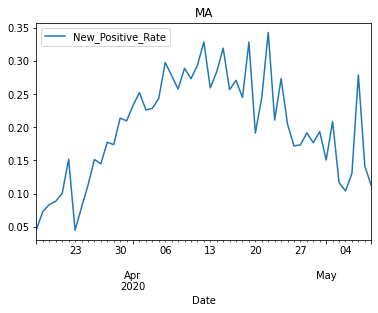

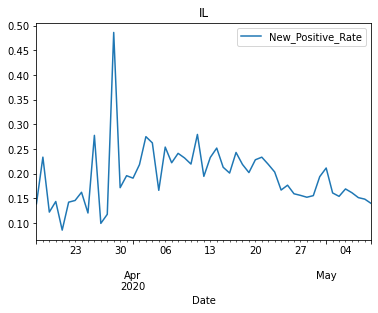

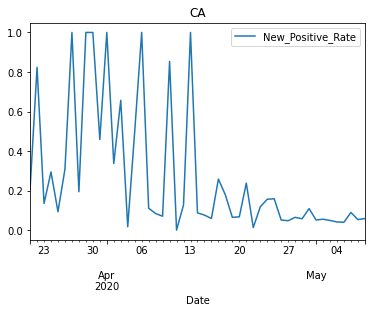

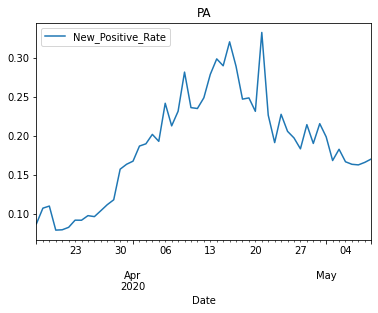

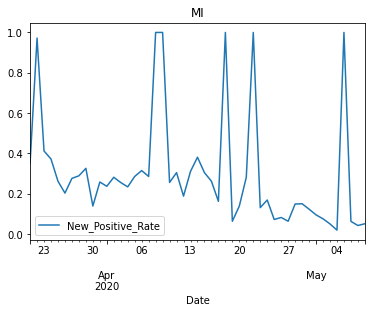

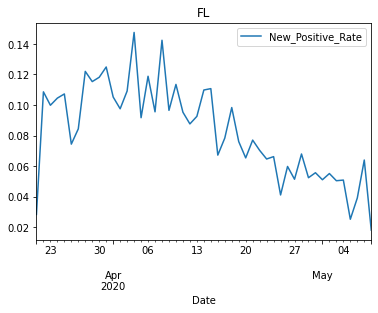

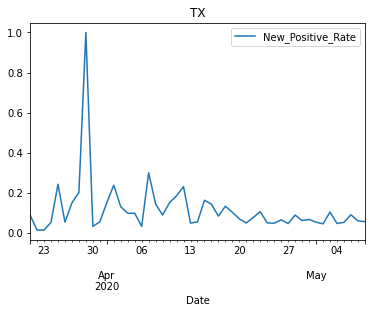

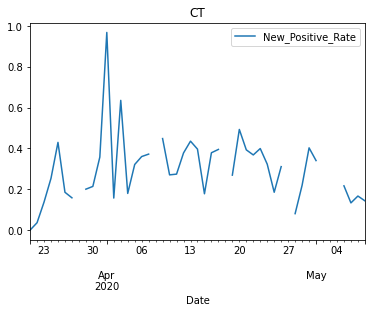

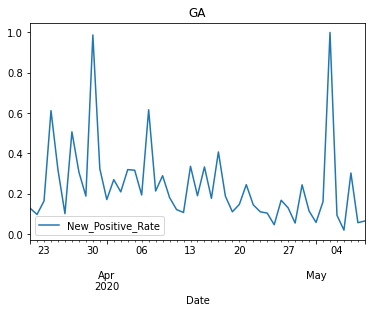

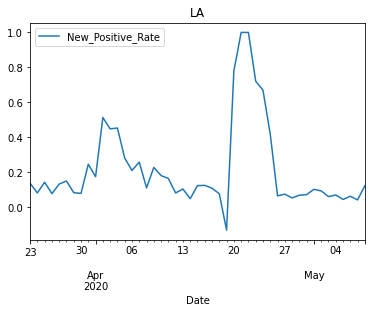

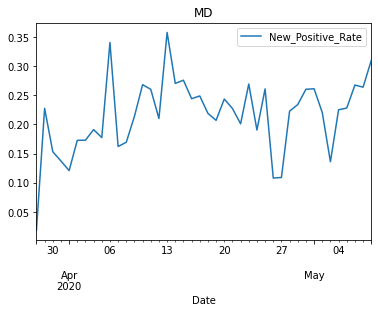

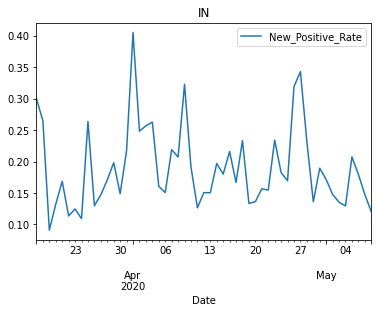

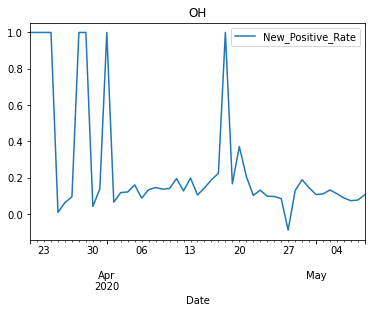

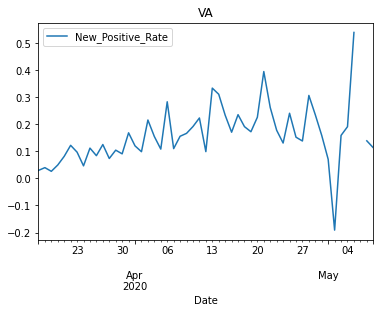

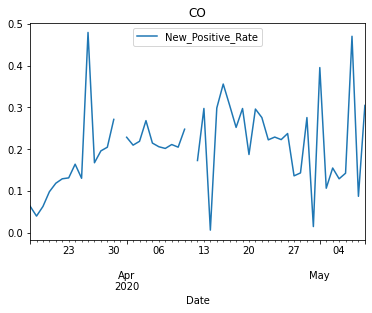

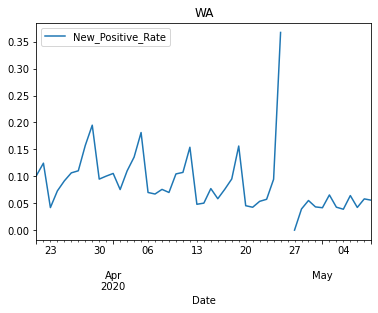

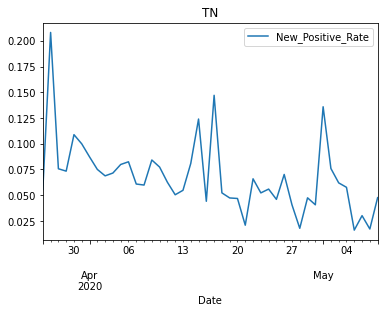

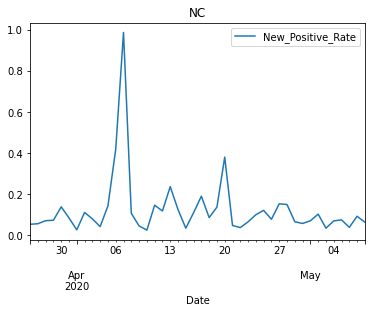

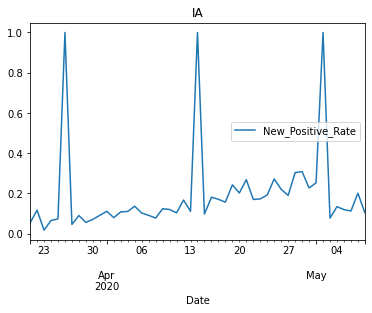

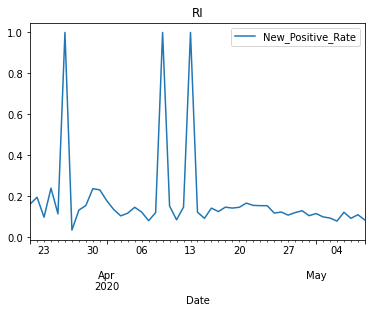

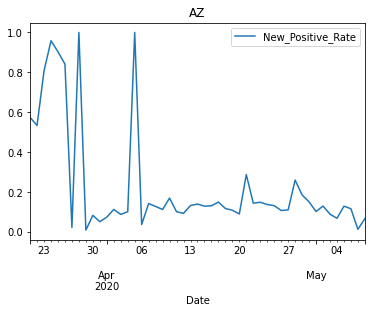

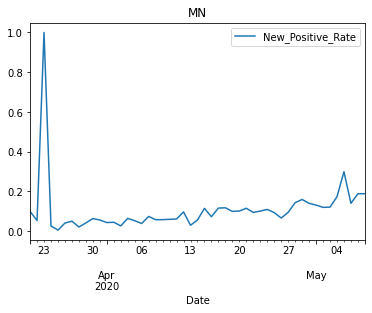

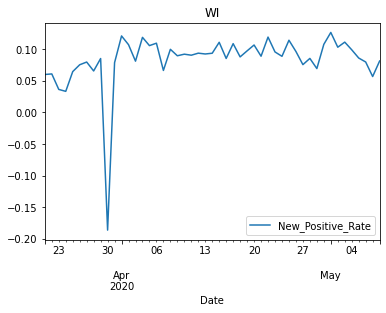

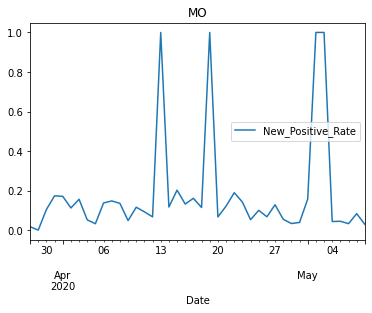

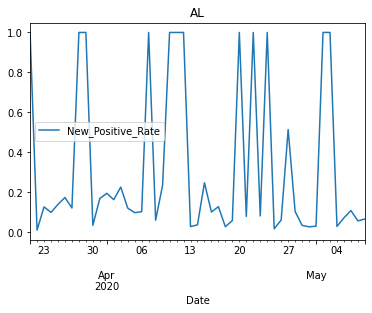

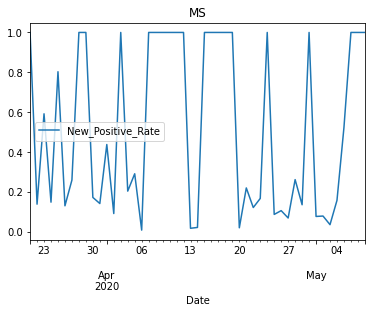

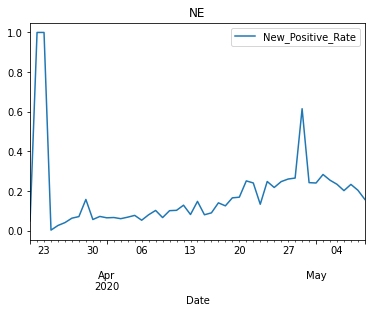

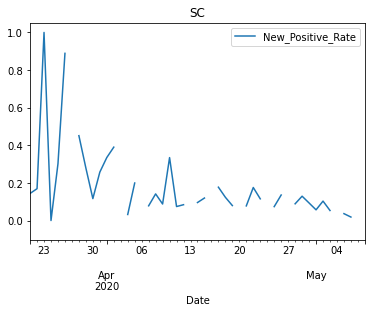

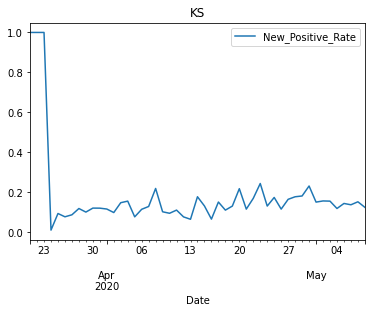

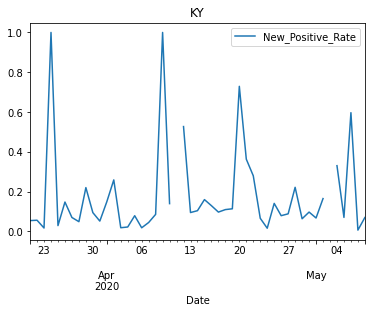

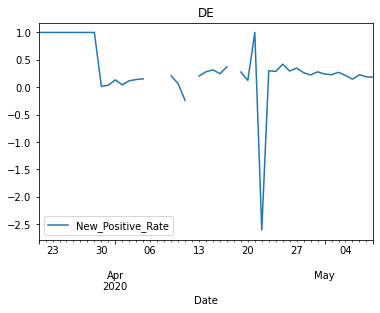

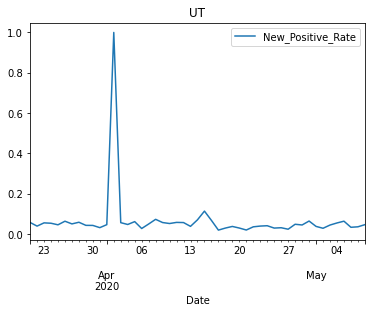

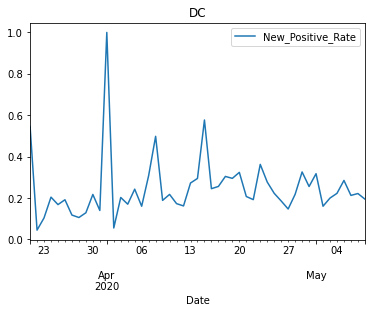

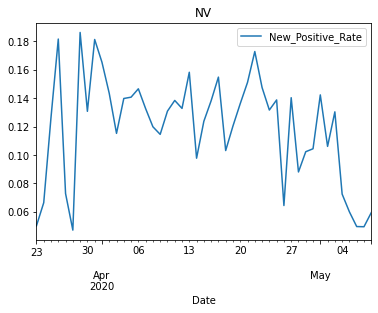

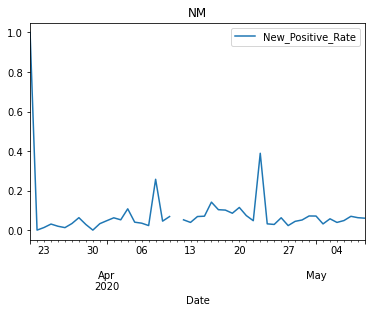

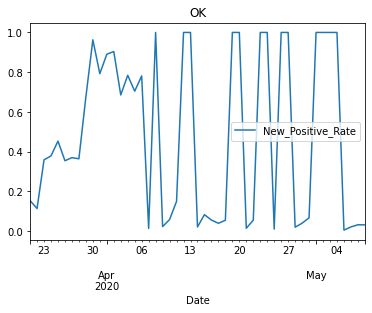

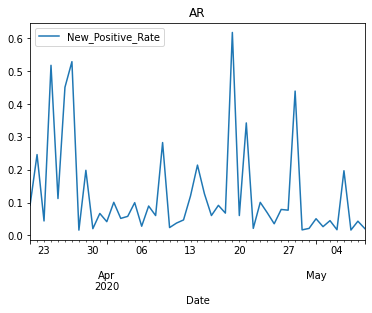

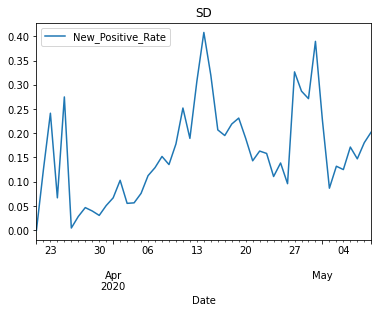

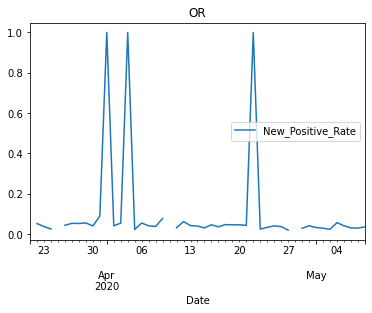

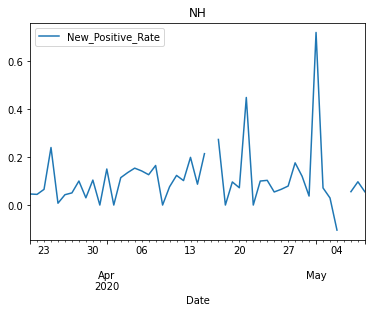

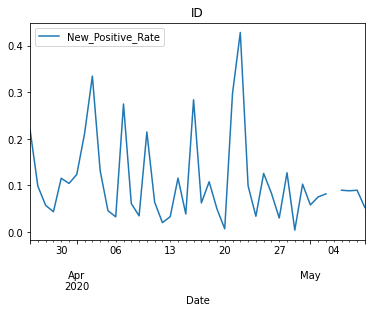

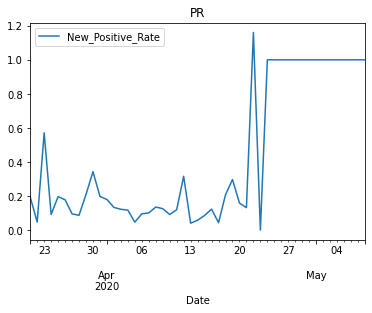

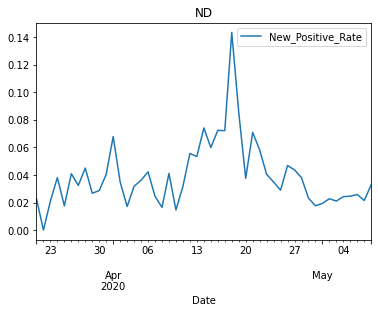

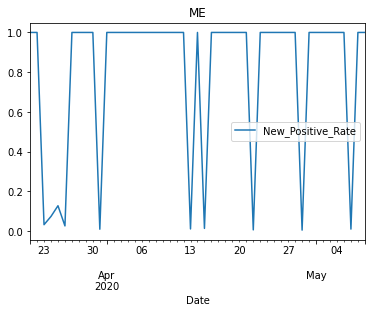

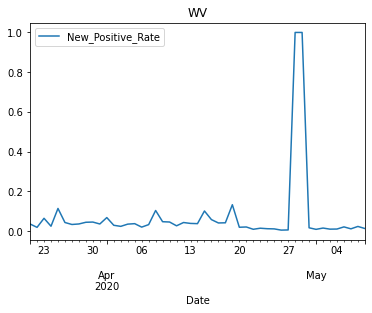

In [17]:
# Plot time series of fraction of NEW tests that are positive, by state,
#   with different start dates for different states, 
#   because positive rates stabilized at different times
for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Positives'] = -df['Positive'].diff().shift(-1)
  df['New_Negatives'] = -df['Negative'].diff().shift(-1)
  df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
  if state in ['NY', 'PA', 'MA', 'CO', 'IN', 'VA', 'IL', 'IN']:
    startdate = '2020-03-17'
  elif state in ['NJ', 'NV', 'LA']:
    startdate = '2020-03-23'
  elif state in ['ID', 'NC', 'TN']:
    startdate = '2020-03-26'
  elif state in ['MO', 'MD']:
    startdate = '2020-03-28'
  else:
    startdate = '2020-03-21'
  df[df.Date>=startdate][['Date',
                          'New_Positive_Rate']].set_index('Date'
                             ).plot(y='New_Positive_Rate', title=state)
  plt.show()